# Introduction

Hey, thanks for viewing my Kernel!

If you like my work, please, leave an upvote: it will be really appreciated and it will motivate me in offering more content to the Kaggle community ! 😊

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('../input/tabular-playground-series-jan-2022/train.csv', index_col = 'row_id')
test = pd.read_csv('../input/tabular-playground-series-jan-2022/test.csv', index_col = 'row_id')

In [2]:
display(train['country'].unique())
display(train['store'].unique())
display(train['product'].unique())

array(['Finland', 'Norway', 'Sweden'], dtype=object)

array(['KaggleMart', 'KaggleRama'], dtype=object)

array(['Kaggle Mug', 'Kaggle Hat', 'Kaggle Sticker'], dtype=object)

# Data Preparation

In [3]:
def get_ts_dict(df):
    country_list = ['Finland', 'Norway', 'Sweden']
    store_list = ['KaggleMart', 'KaggleRama']
    product_list = ['Kaggle Mug', 'Kaggle Hat', 'Kaggle Sticker']

    time_series_dict = {}
    for country in country_list:
        for store in store_list:
            for product in product_list:
                selected_pd = df.loc[(df['country'] == country) & (df['store'] == store) & 
                                     (df['product'] == product), ['date', 'num_sold']]
                key = country + '_' + store + '_' + product
                time_series_dict[key] = selected_pd
    return time_series_dict

In [4]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

ts_dict = get_ts_dict(train)
key_list = list(ts_dict.keys())

In [5]:
def ts_plot(ts_dict, key_list, figsize=(24, 24)):
    import datetime as dt
    
    ncols = 2
    nrows = round(len(key_list) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    plt.subplots_adjust(hspace=1.5)
    
    index = 0
    for row in range(nrows):
        for col in range(ncols):
            try:
                key = key_list[index]
                df = ts_dict[key]
            except:
                axes[row][col].set_visible(False)
                index += 1
                continue
            
            sns.lineplot(data=df, x='date', y='num_sold', ax=axes[row][col])
            axes[row][col].set_title(key)
            x_label = pd.date_range(start=min(df['date']), end=max(df['date']), freq='3M').astype(str)
            axes[row][col].set_xticks(x_label)
            axes[row][col].set_xticklabels(x_label, rotation=90)
            for year in df['date'].dt.year:
                axes[row][col].axvline(x = dt.datetime(year, 12, 30), ymin = 0, ymax = 1,
                                       color ='red', linestyle='--')
            index += 1
    plt.show()

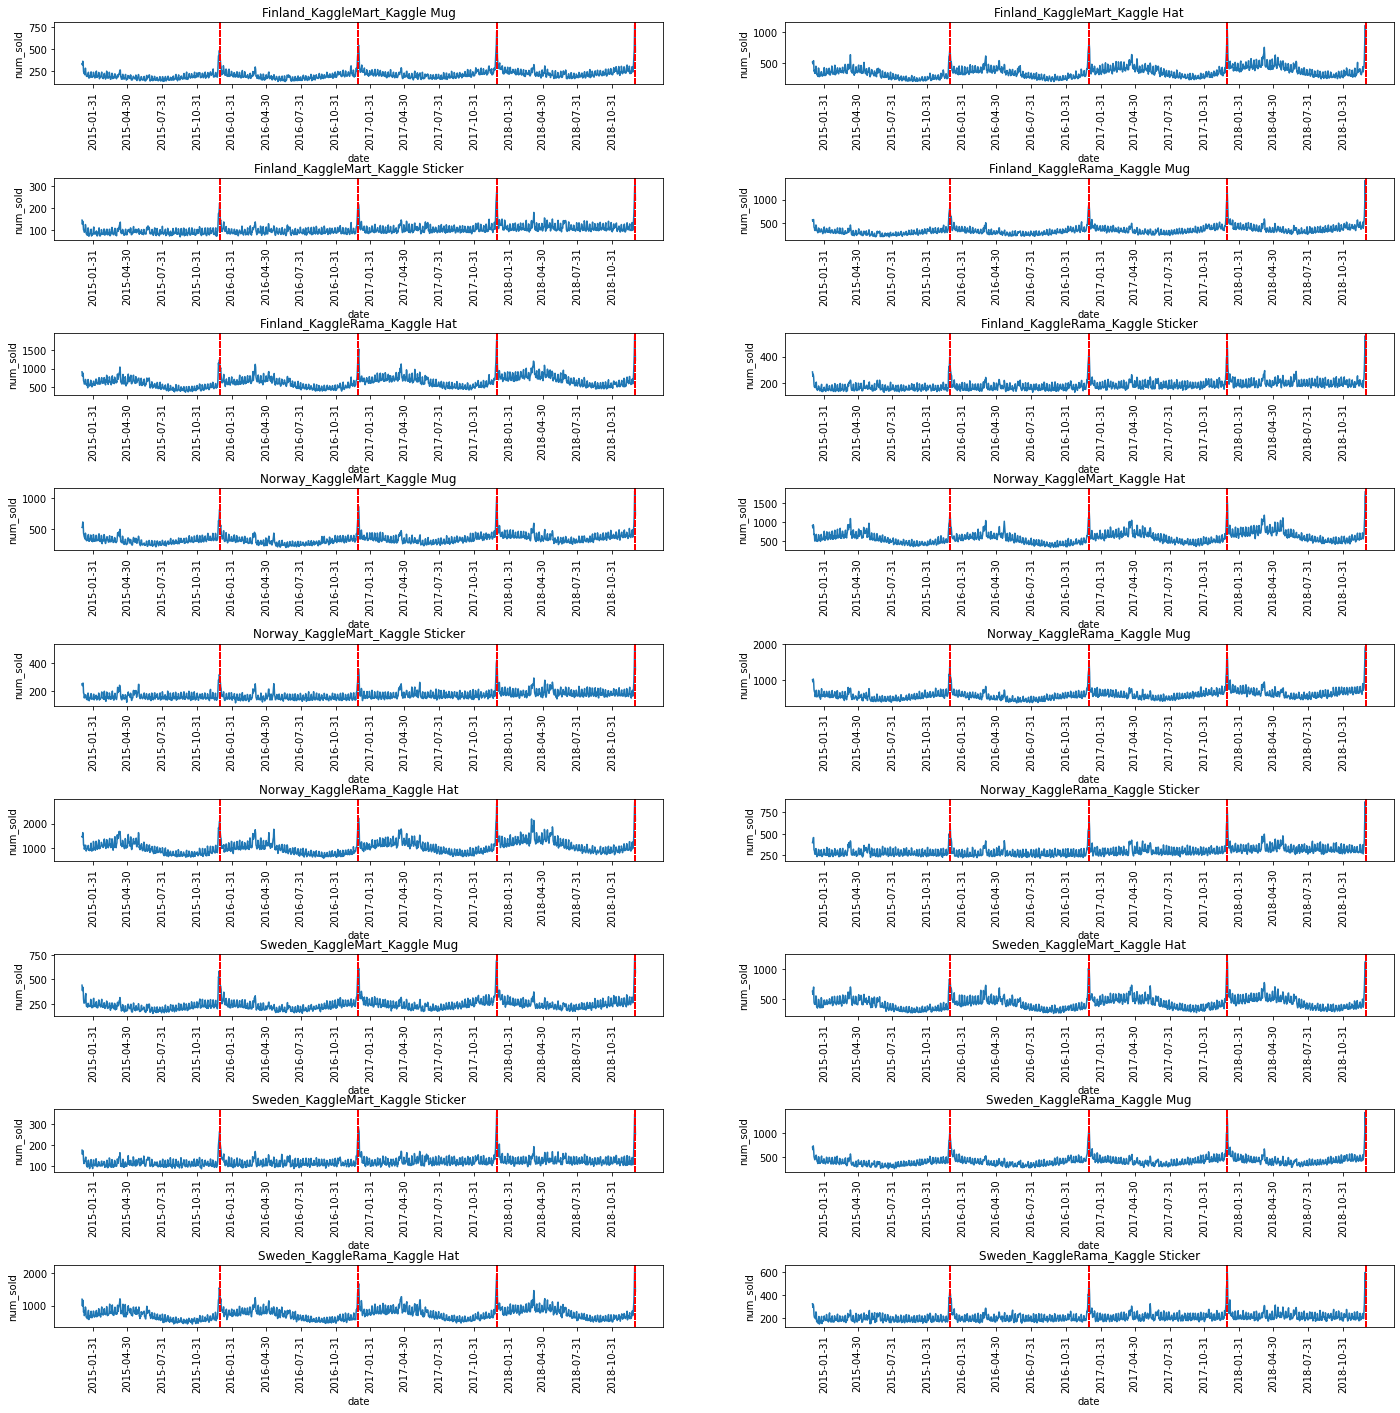

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

ts_plot(ts_dict, key_list)

# Time Series Analysis

In [7]:
def plot_periodogram(ts, detrend='linear', ax=None, title=''):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=90,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram - " + title)
    return ax

In [8]:
df_finland_mart_mug = ts_dict['Finland_KaggleMart_Kaggle Mug'].copy()
df_finland_mart_hat = ts_dict['Finland_KaggleMart_Kaggle Hat'].copy()
df_finland_mart_sticker = ts_dict['Finland_KaggleMart_Kaggle Sticker'].copy()

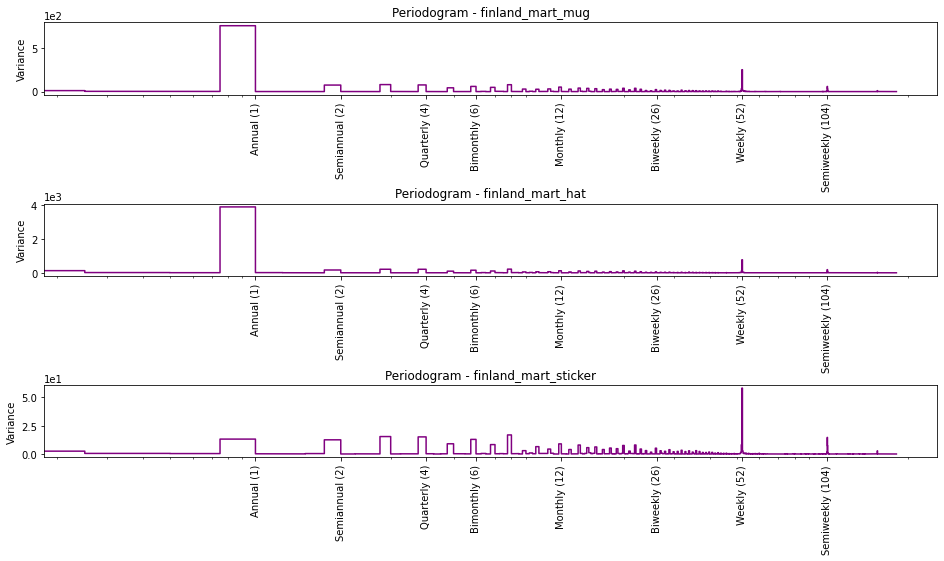

In [9]:
import warnings

warnings.filterwarnings("ignore")

fig, axes = plt.subplots(3, 1, figsize=(16, 8))
plt.subplots_adjust(hspace=1.5)
plot_periodogram(df_finland_mart_mug['num_sold'], ax=axes[0], title='finland_mart_mug')
plot_periodogram(df_finland_mart_hat['num_sold'], ax=axes[1], title='finland_mart_hat')
plot_periodogram(df_finland_mart_sticker['num_sold'], ax=axes[2], title='finland_mart_sticker')
plt.show()

## Mug

In [10]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier_order = 1
fourier = CalendarFourier(freq="A", order=fourier_order)

dp = DeterministicProcess(
    index=df_finland_mart_mug['date'],
    constant=False,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True                   # drop terms to avoid collinearity
)

train_ts_mug = dp.in_sample()
train_ts_mug

,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)"
date,,,,,,,,,,
2015-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000
2015-01-02,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852
2015-01-03,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407
2015-01-04,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667
2015-01-05,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630
...,...,...,...,...,...,...,...,...,...,...
2018-12-27,1457.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.085965,0.996298
2018-12-28,1458.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.068802,0.997630
2018-12-29,1459.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.051620,0.998667


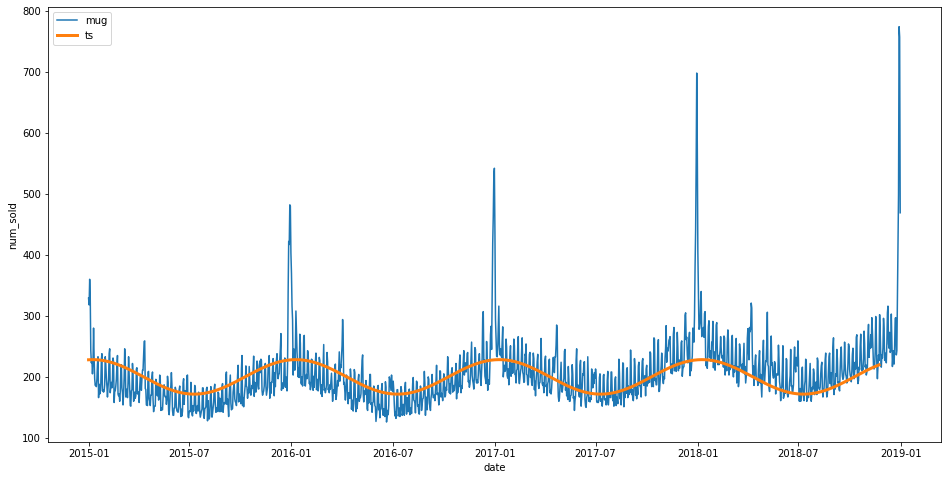

In [11]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x=df_finland_mart_mug['date'], y=df_finland_mart_mug['num_sold'], label='mug', ax=ax)

train_ts_mug['total_wave'] = 0
for i in range(fourier_order):
    train_ts_mug['total_wave'] = (train_ts_mug['total_wave'] + 
                                  train_ts_mug[f'sin({i+1},freq=A-DEC)'] + train_ts_mug[f'cos({i+1},freq=A-DEC)'])
train_ts_mug['total_wave'] *= 20
train_ts_mug['total_wave'] +=200

shift_num = 38
train_ts_mug['total_wave'] = train_ts_mug['total_wave'].shift(-shift_num)
sns.lineplot(x=train_ts_mug.index, y=train_ts_mug['total_wave'], label='ts', ax=ax, linewidth=3)

plt.show()

## Hat

In [12]:
fourier_order = 1
fourier = CalendarFourier(freq="A", order=fourier_order)

dp = DeterministicProcess(
    index=df_finland_mart_hat['date'],
    constant=False,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True                   # drop terms to avoid collinearity
)

train_ts_hat = dp.in_sample()

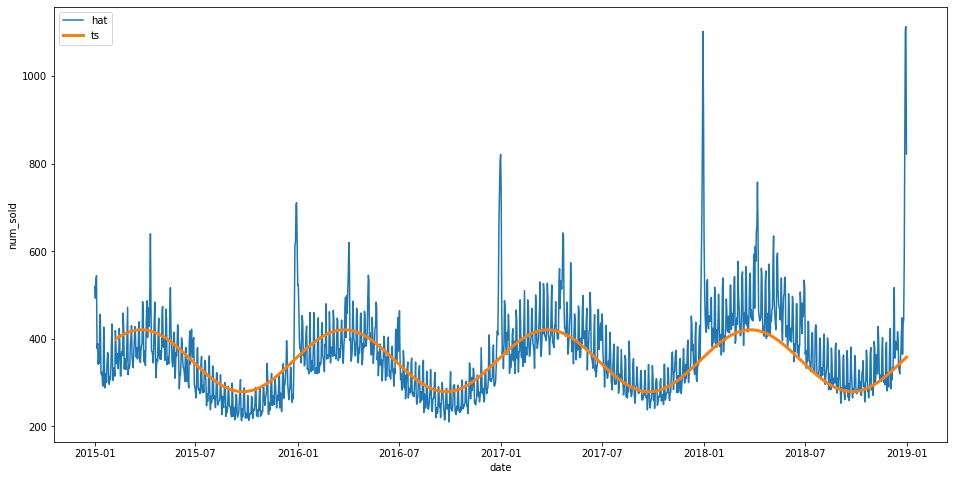

In [13]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x=df_finland_mart_hat['date'], y=df_finland_mart_hat['num_sold'], label='hat', ax=ax)

train_ts_hat['total_wave'] = 0
for i in range(fourier_order):
    train_ts_hat['total_wave'] = (train_ts_hat['total_wave'] + 
                                  train_ts_hat[f'sin({i+1},freq=A-DEC)'] + train_ts_hat[f'cos({i+1},freq=A-DEC)'])
train_ts_hat['total_wave'] *= 50
train_ts_hat['total_wave'] +=350

train_ts_hat['total_wave'] = train_ts_hat['total_wave'].shift(shift_num)
sns.lineplot(x=train_ts_hat.index, y=train_ts_hat['total_wave'], label='ts', ax=ax, linewidth=3)

plt.show()

# Feature Engineering

In [14]:
def feature_eng(df):
    import holidays
    import datetime
    
    #### Date
    df['date'] = pd.to_datetime(df['date'])
    df['week']= df['date'].dt.week
    df['year'] = 'Y' + df['date'].dt.year.astype(str)
    df['quarter'] = 'Q' + df['date'].dt.quarter.astype(str)
    df['day'] = df['date'].dt.day
    df['dayofyear'] = df['date'].dt.dayofyear
    df.loc[(df.date.dt.is_leap_year) & (df.dayofyear >= 60),'dayofyear'] -= 1
    df['weekend'] = df['date'].dt.weekday >=5
    df['weekday'] = 'WD' + df['date'].dt.weekday.astype(str)
    df['month']= 'M' + df['date'].dt.month.astype(str)
    
    #### Peak
    df['MM-DD'] = df['date'].dt.strftime('%m-%d')
    df['peak'] = 0
    df.loc[df['MM-DD'] == '12-26', 'peak'] = 0.25
    df.loc[df['MM-DD'] == '12-27', 'peak'] = 0.50
    df.loc[df['MM-DD'] == '12-28', 'peak'] = 0.75
    df.loc[df['MM-DD'] == '12-29', 'peak'] = 1
    df.loc[df['MM-DD'] == '12-30', 'peak'] = 1
    df.loc[df['MM-DD'] == '12-31', 'peak'] = 1
    df.loc[df['MM-DD'] == '01-01', 'peak'] = 0.75
    df.loc[df['MM-DD'] == '01-02', 'peak'] = 0.50
    df.loc[df['MM-DD'] == '01-03', 'peak'] = 0.25
    
    #### Till The Next Holiday
    def get_country_holidays(country, years_list):
        festivities = holidays.CountryHoliday(country, years=years_list)
        festivities_df = pd.DataFrame.from_dict(festivities, orient='index').reset_index().rename(columns={'index':'date', 0:'festivity_name'})
        festivities_df['date'] = pd.to_datetime(festivities_df['date'])
        if country == 'Sweden':
            festivities_df = festivities_df[festivities_df['festivity_name']!='Söndag']

        additional_dates = [[pd.to_datetime(f'{year}-12-24'), 'Christmas Eve'] for year in years_list]
        additional_dates += [[pd.to_datetime(f'{year}-12-29'), 'Peak in sales 1/2'] for year in years_list]
        additional_dates += [[pd.to_datetime(f'{year}-12-30'), 'Peak in sales 2/2'] for year in years_list]
        additional_dates += [[pd.to_datetime(f'{year}-12-31'), 'Saint Sylvester'] for year in years_list]
        additional_dates += [[pd.to_datetime(f'{year}-01-01'), 'New Year'] for year in years_list]
        additional_festivities_df = pd.DataFrame(additional_dates, columns=['date', 'festivity_name'])    

        festivities_df = festivities_df.append(additional_festivities_df, ignore_index=True)
        return festivities_df.sort_values('date')

    def days_till_next_holiday(country, date):
        country_holidays_dates = get_country_holidays(country, [date.year, date.year+1])['date']
        next_date = min([holidays_date for holidays_date in country_holidays_dates if holidays_date >= date])
        return (next_date - date).days
    
    df['days_till_next_holiday'] = df.apply(lambda x: days_till_next_holiday(x['country'], x['date']), axis=1)
    
    #### Seasonality
    date_range = pd.date_range(start=min(df['date'] + datetime.timedelta(days=-60)), 
                               end=max(df['date'] + datetime.timedelta(days=60)), freq='D')
    fourier = CalendarFourier(freq="A", order=1)
    dp = DeterministicProcess(
            index=date_range,
            constant=False,               # dummy feature for bias (y-intercept)
            order=1,                     # trend (order 1 means linear)
            seasonal=True,               # weekly seasonality (indicators)
            additional_terms=[fourier],  # annual seasonality (fourier)
            drop=True                   # drop terms to avoid collinearity
    )
    ts_features = dp.in_sample()
    ts_features['wave'] = ts_features['sin(1,freq=A-DEC)'] + ts_features['cos(1,freq=A-DEC)']
    ts_features['wave_mug'] = ts_features['wave'].shift(-shift_num)
    ts_features['wave_mug_lag1'] = ts_features['wave'].shift(-shift_num - 1)
    ts_features['wave_mug_lag2'] = ts_features['wave'].shift(-shift_num - 2)
    ts_features['wave_mug_lag3'] = ts_features['wave'].shift(-shift_num - 3)
    ts_features['wave_hat'] = ts_features['wave'].shift(shift_num)
    ts_features['wave_hat_lag1'] = ts_features['wave'].shift(shift_num - 1)
    ts_features['wave_hat_lag2'] = ts_features['wave'].shift(shift_num - 2)
    ts_features['wave_hat_lag3'] = ts_features['wave'].shift(shift_num - 3)
    ts_features.drop(['sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)'], inplace=True, axis=1)
    df = df.merge(ts_features, left_on='date', right_index=True)
    
    #### GDP
    gdp_df = pd.read_csv('../input/gdp-data-2014-to-2019-finland-norway-sweden/GDP_data_2014_to_2019_Finland_Norway_Sweden.csv', sep=';')
    gdp_df.columns = ['year', 'Finland', 'Norway', 'Sweden']

    gdp_melt_df = pd.melt(gdp_df, id_vars=['year'], value_vars=['Finland', 'Norway', 'Sweden'], var_name='country', value_name='gdp')
    gdp_melt_df['year'] = 'Y' + gdp_melt_df['year'].astype(str)
    df = df.merge(gdp_melt_df, how='left', on=['year', 'country'])
    
    #### DGP Percentage Change Between Years
    gdp_df['Finland'] = gdp_df['Finland'].pct_change()
    gdp_df['Norway'] = gdp_df['Norway'].pct_change()
    gdp_df['Sweden'] = gdp_df['Sweden'].pct_change()
    
    gdp_melt_df = pd.melt(gdp_df, id_vars=['year'], value_vars=['Finland', 'Norway', 'Sweden'], var_name='country', value_name='gdp_pct')
    gdp_melt_df['year'] = 'Y' + gdp_melt_df['year'].astype(str)
    df = df.merge(gdp_melt_df, how='left', on=['year', 'country'])
    
    df.drop(columns=['date', 'MM-DD'],inplace=True) 
    return df

In [15]:
train_test = pd.concat([train, test])
train_test = feature_eng(train_test)

train_new = train_test.iloc[:len(train), :]
test_new = train_test.iloc[len(train):, :]
test_new.drop(['num_sold'], axis=1, inplace=True)

In [16]:
train_new

,country,store,product,num_sold,week,year,quarter,day,dayofyear,weekend,...,wave_mug,wave_mug_lag1,wave_mug_lag2,wave_mug_lag3,wave_hat,wave_hat_lag1,wave_hat_lag2,wave_hat_lag3,gdp,gdp_pct
0,Finland,KaggleMart,Kaggle Mug,329.0,1,Y2015,Q1,1,1,False,...,1.402048,1.405027,1.407589,1.409734,0.185095,0.209201,0.233246,0.257221,234.440,0.017977
1,Finland,KaggleMart,Kaggle Hat,520.0,1,Y2015,Q1,1,1,False,...,1.402048,1.405027,1.407589,1.409734,0.185095,0.209201,0.233246,0.257221,234.440,0.017977
2,Finland,KaggleMart,Kaggle Sticker,146.0,1,Y2015,Q1,1,1,False,...,1.402048,1.405027,1.407589,1.409734,0.185095,0.209201,0.233246,0.257221,234.440,0.017977
3,Finland,KaggleRama,Kaggle Mug,572.0,1,Y2015,Q1,1,1,False,...,1.402048,1.405027,1.407589,1.409734,0.185095,0.209201,0.233246,0.257221,234.440,0.017977
4,Finland,KaggleRama,Kaggle Hat,911.0,1,Y2015,Q1,1,1,False,...,1.402048,1.405027,1.407589,1.409734,0.185095,0.209201,0.233246,0.257221,234.440,0.017977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26293,Sweden,KaggleMart,Kaggle Hat,823.0,1,Y2018,Q4,31,365,False,...,1.398655,1.402048,1.405027,1.407589,0.160933,0.185095,0.209201,0.233246,555.455,0.026683
26294,Sweden,KaggleMart,Kaggle Sticker,250.0,1,Y2018,Q4,31,365,False,...,1.398655,1.402048,1.405027,1.407589,0.160933,0.185095,0.209201,0.233246,555.455,0.026683
26295,Sweden,KaggleRama,Kaggle Mug,1004.0,1,Y2018,Q4,31,365,False,...,1.398655,1.402048,1.405027,1.407589,0.160933,0.185095,0.209201,0.233246,555.455,0.026683
26296,Sweden,KaggleRama,Kaggle Hat,1441.0,1,Y2018,Q4,31,365,False,...,1.398655,1.402048,1.405027,1.407589,0.160933,0.185095,0.209201,0.233246,555.455,0.026683


# Modeling

In [17]:
%%capture
!pip install pycaret[full]

In [18]:
NUM_FEATURES = list(test_new.loc[:,test_new.dtypes==np.int].columns)
NUM_FEATURES_2 = list(test_new.loc[:,test_new.dtypes==np.float].columns)
NUM_FEATURES.extend(NUM_FEATURES_2)

FEATURES = list(test_new.columns)
CAT_FEATURES = [feature for feature in FEATURES if feature not in NUM_FEATURES]

print(CAT_FEATURES)
print(NUM_FEATURES)

['country', 'store', 'product', 'year', 'quarter', 'weekend', 'weekday', 'month']
['week', 'day', 'dayofyear', 'days_till_next_holiday', 'peak', 'trend', 's(1,7)', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)', 'wave', 'wave_mug', 'wave_mug_lag1', 'wave_mug_lag2', 'wave_mug_lag3', 'wave_hat', 'wave_hat_lag1', 'wave_hat_lag2', 'wave_hat_lag3', 'gdp', 'gdp_pct']


In [19]:
from pycaret.regression import *

reg = setup(data = train_new,
            target = 'num_sold',
            normalize = True, #normalisation helps some algorithms
            normalize_method = 'robust', #resilient to outliers
            transform_target = True, #applies transformation to target column
            transform_target_method = 'box-cox',
            data_split_shuffle = False, #so that we do not use "future" observations to predict "past" observations
            create_clusters = True,
            feature_interaction = True,
            categorical_features = CAT_FEATURES,
            numeric_features = NUM_FEATURES,
            session_id = 42,
            use_gpu = False,
            silent = True,
            fold = 10,
            n_jobs = -1)

,Description,Value
0,session_id,42
1,Target,num_sold
2,Original Data,"(26298, 33)"
3,Missing Values,False
4,Numeric Features,24
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(18408, 84)"


In [20]:
# Credit to https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/36414
def SMAPE(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

add_metric('SMAPE', 'SMAPE', SMAPE, greater_is_better=False)

Name                                                       SMAPE
Display Name                                               SMAPE
Score Function                <function SMAPE at 0x7fab97008710>
Scorer               make_scorer(SMAPE, greater_is_better=False)
Target                                                      pred
Args                                                          {}
Greater is Better                                          False
Custom                                                      True
Name: SMAPE, dtype: object

In [21]:
N = 3
top = compare_models(sort = 'SMAPE', n_select = N)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
catboost,CatBoost Regressor,23.7103,1991.2720,41.5029,0.9721,0.0798,0.0591,5.9570,9.5240
lightgbm,Light Gradient Boosting Machine,24.9597,2170.8556,43.8055,0.9690,0.0847,0.0628,6.2936,0.4290
xgboost,Extreme Gradient Boosting,26.5446,2193.4937,44.0476,0.9686,0.0890,0.0675,6.7510,32.8810
gbr,Gradient Boosting Regressor,27.8183,2657.0571,48.4481,0.9620,0.0918,0.0691,6.9533,3.1770
rf,Random Forest Regressor,28.1337,2581.6491,48.5702,0.9612,0.0931,0.0697,6.9743,11.4860
et,Extra Trees Regressor,28.1915,2586.6042,48.3168,0.9615,0.0947,0.0715,7.1339,6.5800
huber,Huber Regressor,26.3007,1914.4178,41.5210,0.9716,0.0943,0.0719,7.2261,0.6290
lr,Linear Regression,26.6844,1951.8980,41.8558,0.9708,0.0947,0.0725,7.2986,0.5480
ridge,Ridge Regression,26.9412,1983.6102,42.3003,0.9704,0.0951,0.0731,7.3357,0.0410
br,Bayesian Ridge,27.0127,2000.0828,42.4635,0.9702,0.0956,0.0733,7.3679,0.1110


In [22]:
#tuned_top = [tune_model(i, optimize = 'SMAPE', choose_better=True, n_iter=100) for i in top]

In [23]:
blend = blend_models(top, optimize='SMAPE')
predict_model(blend);

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,30.5022,2577.3894,50.7680,0.9677,0.0949,0.0732,7.2566
1,27.6779,2200.5279,46.9098,0.9682,0.0938,0.0736,7.1557
2,15.5359,475.5850,21.8079,0.9850,0.0638,0.0528,5.1244
3,23.0478,1554.3176,39.4248,0.9770,0.0720,0.0564,5.6332
4,31.9414,4133.0778,64.2890,0.9502,0.1102,0.0700,7.4288
5,19.0803,948.5324,30.7983,0.9784,0.0717,0.0578,5.6078
6,14.8923,457.6970,21.3939,0.9856,0.0595,0.0459,4.6408
7,29.8959,3084.8494,55.5414,0.9652,0.0858,0.0616,6.2000
8,31.9954,3795.8905,61.6108,0.9571,0.1065,0.0693,7.3241
9,15.7793,535.3265,23.1371,0.9861,0.0559,0.0450,4.4930


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Voting Regressor,35.0710,3632.4946,60.2702,0.9571,0.0953,0.0732,7.5874


In [24]:
final_blend = finalize_model(blend)
predict_model(final_blend);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Voting Regressor,15.6007,538.7728,23.2115,0.9936,0.0473,0.0378,3.7711


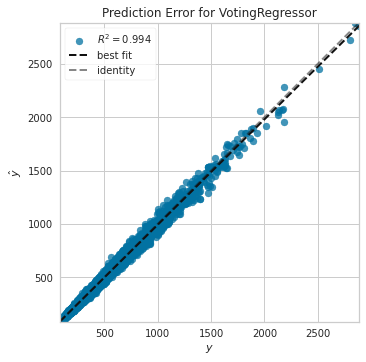

In [25]:
plot_model(final_blend, plot='error')

In [26]:
import gc
gc.collect()
unseen_predictions_blend = predict_model(final_blend, data=test_new)
unseen_predictions_blend.head()

,country,store,product,week,year,quarter,day,dayofyear,weekend,weekday,...,wave_mug_lag1,wave_mug_lag2,wave_mug_lag3,wave_hat,wave_hat_lag1,wave_hat_lag2,wave_hat_lag3,gdp,gdp_pct,Label
26298,Finland,KaggleMart,Kaggle Mug,1,Y2019,Q1,1,1,False,WD1,...,1.405027,1.407589,1.409734,0.185095,0.209201,0.233246,0.257221,268.782,-0.024668,402.124754
26299,Finland,KaggleMart,Kaggle Hat,1,Y2019,Q1,1,1,False,WD1,...,1.405027,1.407589,1.409734,0.185095,0.209201,0.233246,0.257221,268.782,-0.024668,580.972924
26300,Finland,KaggleMart,Kaggle Sticker,1,Y2019,Q1,1,1,False,WD1,...,1.405027,1.407589,1.409734,0.185095,0.209201,0.233246,0.257221,268.782,-0.024668,178.842400
26301,Finland,KaggleRama,Kaggle Mug,1,Y2019,Q1,1,1,False,WD1,...,1.405027,1.407589,1.409734,0.185095,0.209201,0.233246,0.257221,268.782,-0.024668,714.544045
26302,Finland,KaggleRama,Kaggle Hat,1,Y2019,Q1,1,1,False,WD1,...,1.405027,1.407589,1.409734,0.185095,0.209201,0.233246,0.257221,268.782,-0.024668,1010.902232


In [27]:
gc.collect()

assert(len(test.index)==len(unseen_predictions_blend))

sub = pd.DataFrame(list(zip(test.index, unseen_predictions_blend.Label)),columns = ['row_id', 'num_sold'])

sub.to_csv('submission.csv', index = False)

print(sub)

      row_id     num_sold
0      26298   402.124754
1      26299   580.972924
2      26300   178.842400
3      26301   714.544045
4      26302  1010.902232
...      ...          ...
6565   32863   806.106406
6566   32864   259.659169
6567   32865   814.038584
6568   32866  1383.139089
6569   32867   399.225540

[6570 rows x 2 columns]
